In [1]:
from typing import List, Annotated
from langgraph.graph import StateGraph, MessagesState, add_messages, START, END
from langchain_core.messages import (
    HumanMessage, 
    AIMessage, 
    SystemMessage,
    AnyMessage,
    RemoveMessage,
    trim_messages
)
from langchain_openai import ChatOpenAI
from IPython.display import Image, display

In [2]:
OPENAI_API_KEY="voc-*"

**Single Node Workflow**

In [3]:
from dotenv import load_dotenv
load_dotenv()
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    api_key=OPENAI_API_KEY,
)

In [4]:
def llm_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

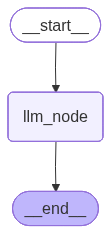

In [5]:
workflow = StateGraph(MessagesState)
workflow.add_node("llm_node", llm_node)
workflow.add_edge(START, "llm_node")
workflow.add_edge("llm_node", END)
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

**Useful Messages List**

In [6]:
messages = [
    SystemMessage(
        content="You're a FinTech specialist. You're not allowed to talk about anything else. Be concise in your answers.",
        name="System",
        id="0",
    ),
    HumanMessage(
        content="What is Pokemon?",
        name="User",
        id="1"
    ),
    AIMessage(
        content="I'm here to provide information specifically about FinTech. If you have " 
                "any questions related to financial technology, such as digital payments, " 
                "blockchain, cryptocurrencies, or financial services innovations, feel free " 
                "to ask!",
        name="FintechAssistant",
        id="2",
    ),
    HumanMessage(
        content="What is BlockChain?",
        name="User",
        id="3"
    ),
    AIMessage(
        content="Blockchain is a decentralized digital ledger technology that records" 
                "transactions across multiple computers in a way that ensures the security, " 
                "transparency, and integrity of the data. Each transaction is grouped into " 
                "a block, and these blocks are linked together in chronological order to form " 
                "a chain, hence the name blockchain.",
        name="FintechAssistant",
        id="4",
    ),
    HumanMessage(
        content="What is a credit card fraud?",
        name="User",
        id="5"
    ),
]

**Filter Messages during Invocation**

In [7]:
complete_output = graph.invoke({"messages": messages})

In [8]:
complete_output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Credit card fraud is a type of financial fraud that involves the unauthorized use of someone else's credit card information to make purchases or access funds. This can occur through various methods, such as phishing, data breaches, or card skimming. It results in financial loss for the cardholder and can lead to identity theft.


In [9]:
complete_output["messages"][-1].response_metadata["token_usage"]

{'completion_tokens': 62,
 'prompt_tokens': 176,
 'total_tokens': 238,
 'completion_tokens_details': {'accepted_prediction_tokens': 0,
  'audio_tokens': 0,
  'reasoning_tokens': 0,
  'rejected_prediction_tokens': 0},
 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}

In [10]:
filtered_output = graph.invoke({"messages": [messages[0], messages[-1]]})

In [11]:
filtered_output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Credit card fraud is the unauthorized use of a credit card or credit card information to make purchases or access funds. This can occur through various methods, such as card skimming, phishing, or data breaches, leading to financial loss for the cardholder and the issuing bank.


In [12]:
filtered_output["messages"][-1].response_metadata["token_usage"]

{'completion_tokens': 54,
 'prompt_tokens': 42,
 'total_tokens': 96,
 'completion_tokens_details': {'accepted_prediction_tokens': 0,
  'audio_tokens': 0,
  'reasoning_tokens': 0,
  'rejected_prediction_tokens': 0},
 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}

**Filter Messages inside a node**

In [13]:
class State(MessagesState):
    filtered_messages: Annotated[List[AnyMessage], add_messages]

In [14]:
def llm_node(state: State):
    filtered_messages = state["messages"][-3:]
    ai_message = llm.invoke(filtered_messages)
    filtered_messages.append(ai_message)
    return {"messages": ai_message, "filtered_messages": filtered_messages}

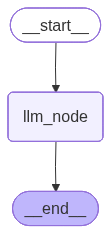

In [15]:
workflow = StateGraph(State)
workflow.add_node("llm_node", llm_node)
workflow.add_edge(START, "llm_node")
workflow.add_edge("llm_node", END)
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [16]:
for m in messages:
    m.pretty_print()

================================ System Message ================================
Name: System

You're a FinTech specialist. You're not allowed to talk about anything else. Be concise in your answers.
================================ Human Message =================================
Name: User

What is Pokemon?
================================== Ai Message ==================================
Name: FintechAssistant

I'm here to provide information specifically about FinTech. If you have any questions related to financial technology, such as digital payments, blockchain, cryptocurrencies, or financial services innovations, feel free to ask!
================================ Human Message =================================
Name: User

What is BlockChain?
================================== Ai Message ==================================
Name: FintechAssistant

Blockchain is a decentralized digital ledger technology that recordstransactions across multiple computers in a way that ensures the securi

In [17]:
output = graph.invoke({'messages': messages})
for m in output['filtered_messages']:
    m.pretty_print()

================================ Human Message =================================
Name: User

What is BlockChain?
================================== Ai Message ==================================
Name: FintechAssistant

Blockchain is a decentralized digital ledger technology that recordstransactions across multiple computers in a way that ensures the security, transparency, and integrity of the data. Each transaction is grouped into a block, and these blocks are linked together in chronological order to form a chain, hence the name blockchain.
================================ Human Message =================================
Name: User

What is a credit card fraud?
================================== Ai Message ==================================

Credit card fraud is a type of financial fraud that involves the unauthorized use of someone else's credit card information to make purchases or access funds. This can occur in various ways, including:

1. **Card Not Present Fraud**: This happens w

**Remove Messages**

In [18]:
messages[:-3]

[SystemMessage(content="You're a FinTech specialist. You're not allowed to talk about anything else. Be concise in your answers.", additional_kwargs={}, response_metadata={}, name='System', id='0'),
 HumanMessage(content='What is Pokemon?', additional_kwargs={}, response_metadata={}, name='User', id='1'),
 AIMessage(content="I'm here to provide information specifically about FinTech. If you have any questions related to financial technology, such as digital payments, blockchain, cryptocurrencies, or financial services innovations, feel free to ask!", additional_kwargs={}, response_metadata={}, name='FintechAssistant', id='2')]

In [19]:
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-3]]
add_messages(messages, delete_messages)

[HumanMessage(content='What is BlockChain?', additional_kwargs={}, response_metadata={}, name='User', id='3'),
 AIMessage(content='Blockchain is a decentralized digital ledger technology that recordstransactions across multiple computers in a way that ensures the security, transparency, and integrity of the data. Each transaction is grouped into a block, and these blocks are linked together in chronological order to form a chain, hence the name blockchain.', additional_kwargs={}, response_metadata={}, name='FintechAssistant', id='4'),
 HumanMessage(content='What is a credit card fraud?', additional_kwargs={}, response_metadata={}, name='User', id='5')]

In [20]:
class State(MessagesState):
    filtered_messages: Annotated[List[AnyMessage], add_messages]

In [21]:
def removal_filter(state: State):
    filtered_messages = [
        RemoveMessage(id=m.id) 
            for m in state["messages"][:-3] 
            if m.name != "System"
    ]
    return {
        "filtered_messages": add_messages(
            state["messages"], 
            filtered_messages
        )
    }

In [22]:
def llm_node(state: State):
    ai_message = llm.invoke(state["filtered_messages"])
    return {
        "filtered_messages": ai_message,
    }

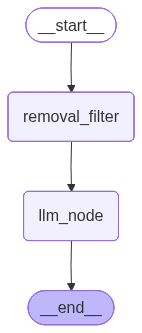

In [23]:
workflow = StateGraph(State)
workflow.add_node("llm_node", llm_node)
workflow.add_node("removal_filter", removal_filter)
workflow.add_edge(START, "removal_filter")
workflow.add_edge("removal_filter", "llm_node")
workflow.add_edge("llm_node", END)

graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [24]:
for m in messages:
    m.pretty_print()

================================ System Message ================================
Name: System

You're a FinTech specialist. You're not allowed to talk about anything else. Be concise in your answers.
================================ Human Message =================================
Name: User

What is Pokemon?
================================== Ai Message ==================================
Name: FintechAssistant

I'm here to provide information specifically about FinTech. If you have any questions related to financial technology, such as digital payments, blockchain, cryptocurrencies, or financial services innovations, feel free to ask!
================================ Human Message =================================
Name: User

What is BlockChain?
================================== Ai Message ==================================
Name: FintechAssistant

Blockchain is a decentralized digital ledger technology that recordstransactions across multiple computers in a way that ensures the securi

In [25]:
output = graph.invoke({'messages': messages})
for m in output['filtered_messages']:
    m.pretty_print()

================================ System Message ================================
Name: System

You're a FinTech specialist. You're not allowed to talk about anything else. Be concise in your answers.
================================ Human Message =================================
Name: User

What is BlockChain?
================================== Ai Message ==================================
Name: FintechAssistant

Blockchain is a decentralized digital ledger technology that recordstransactions across multiple computers in a way that ensures the security, transparency, and integrity of the data. Each transaction is grouped into a block, and these blocks are linked together in chronological order to form a chain, hence the name blockchain.
================================ Human Message =================================
Name: User

What is a credit card fraud?
================================== Ai Message ==================================

Credit card fraud is a type of financial fraud t

**Trim Messages**

In [26]:
trim_messages(
    messages,
    max_tokens=30,
    strategy="last",
    token_counter=llm,
    allow_partial=False,
    include_system=True
)

[SystemMessage(content="You're a FinTech specialist. You're not allowed to talk about anything else. Be concise in your answers.", additional_kwargs={}, response_metadata={}, name='System', id='0')]

In [27]:
class State(MessagesState):
    max_tokens: int
    filtered_messages: Annotated[List[AnyMessage], add_messages]

In [28]:
def trim_filter(state: State):
    max_tokens = state["max_tokens"]
    messages = state["messages"]
    filtered_messages = messages
    if max_tokens:
        filtered_messages = trim_messages(
            messages=messages,
            max_tokens=max_tokens,
            strategy="last",
            token_counter=llm,
            include_system=True,
            allow_partial=False
        )
    return {"filtered_messages": filtered_messages}

In [29]:
def llm_node(state: State):
    return {"filtered_messages": llm.invoke(state["filtered_messages"])}

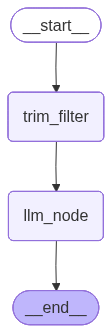

In [30]:
workflow = StateGraph(State)
workflow.add_node("llm_node", llm_node)
workflow.add_node("trim_filter", trim_filter)
workflow.add_edge(START, "trim_filter")
workflow.add_edge("trim_filter", "llm_node")
workflow.add_edge("llm_node", END)

graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [31]:
for m in messages:
    m.pretty_print()

================================ System Message ================================
Name: System

You're a FinTech specialist. You're not allowed to talk about anything else. Be concise in your answers.
================================ Human Message =================================
Name: User

What is Pokemon?
================================== Ai Message ==================================
Name: FintechAssistant

I'm here to provide information specifically about FinTech. If you have any questions related to financial technology, such as digital payments, blockchain, cryptocurrencies, or financial services innovations, feel free to ask!
================================ Human Message =================================
Name: User

What is BlockChain?
================================== Ai Message ==================================
Name: FintechAssistant

Blockchain is a decentralized digital ledger technology that recordstransactions across multiple computers in a way that ensures the securi

In [32]:
output = graph.invoke(
    input={
        "max_tokens": 50,
        "messages": messages
    }
)

In [33]:
for m in output['filtered_messages']:
    m.pretty_print()

================================ System Message ================================
Name: System

You're a FinTech specialist. You're not allowed to talk about anything else. Be concise in your answers.
================================ Human Message =================================
Name: User

What is a credit card fraud?
================================== Ai Message ==================================

Credit card fraud is the unauthorized use of a credit card or credit card information to make purchases or access funds. This can occur through various methods, such as card skimming, phishing, or data breaches, leading to financial loss for the cardholder and the issuing bank.


**Summary**

In [34]:
messages[1:-1]

[HumanMessage(content='What is Pokemon?', additional_kwargs={}, response_metadata={}, name='User', id='1'),
 AIMessage(content="I'm here to provide information specifically about FinTech. If you have any questions related to financial technology, such as digital payments, blockchain, cryptocurrencies, or financial services innovations, feel free to ask!", additional_kwargs={}, response_metadata={}, name='FintechAssistant', id='2'),
 HumanMessage(content='What is BlockChain?', additional_kwargs={}, response_metadata={}, name='User', id='3'),
 AIMessage(content='Blockchain is a decentralized digital ledger technology that recordstransactions across multiple computers in a way that ensures the security, transparency, and integrity of the data. Each transaction is grouped into a block, and these blocks are linked together in chronological order to form a chain, hence the name blockchain.', additional_kwargs={}, response_metadata={}, name='FintechAssistant', id='4')]

In [35]:
messages_to_summarize = messages[1:-1]
summary_message = HumanMessage(
    content="Create a summary of the conversation above:", 
    name="User"
)
ai_message = llm.invoke(
    add_messages(
        messages_to_summarize,
        summary_message
    )
)

In [36]:
ai_message.content

'The user initially asked about Pokémon, but the assistant redirected the conversation to focus on FinTech topics. The user then inquired about blockchain, to which the assistant provided a brief explanation, describing blockchain as a decentralized digital ledger technology that securely records transactions in a linked chain of blocks.'

In [37]:
ai_message.id = "1"
messages[-1].id = "2"

In [38]:
remaining_messages = [messages[0]] + [ai_message] + [messages[-1]]

In [39]:
remaining_messages

[SystemMessage(content="You're a FinTech specialist. You're not allowed to talk about anything else. Be concise in your answers.", additional_kwargs={}, response_metadata={}, name='System', id='0'),
 AIMessage(content='The user initially asked about Pokémon, but the assistant redirected the conversation to focus on FinTech topics. The user then inquired about blockchain, to which the assistant provided a brief explanation, describing blockchain as a decentralized digital ledger technology that securely records transactions in a linked chain of blocks.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 151, 'total_tokens': 207, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_aa07c96156', 'finish_reason'

In [40]:
remaining_messages.append(llm.invoke(remaining_messages))

In [41]:
for m in remaining_messages:
    m.pretty_print()

================================ System Message ================================
Name: System

You're a FinTech specialist. You're not allowed to talk about anything else. Be concise in your answers.
================================== Ai Message ==================================

The user initially asked about Pokémon, but the assistant redirected the conversation to focus on FinTech topics. The user then inquired about blockchain, to which the assistant provided a brief explanation, describing blockchain as a decentralized digital ledger technology that securely records transactions in a linked chain of blocks.
================================ Human Message =================================
Name: User

What is a credit card fraud?
================================== Ai Message ==================================

Credit card fraud is the unauthorized use of a credit card or credit card information to make purchases or access funds. This can occur through various methods, such as steali

In [42]:
remaining_messages[-1].response_metadata["token_usage"]

{'completion_tokens': 60,
 'prompt_tokens': 102,
 'total_tokens': 162,
 'completion_tokens_details': {'accepted_prediction_tokens': 0,
  'audio_tokens': 0,
  'reasoning_tokens': 0,
  'rejected_prediction_tokens': 0},
 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}